In [1]:
%load_ext autoreload
%autoreload 2

from matplotlib import pyplot as plt
import utils.visualisations
import numpy as np
import torch
import torch.nn as nn
import torchvision.datasets
import torchvision.transforms as transforms

import utils.metrics
import utils.model

import models.mnist
import models.resnet
import models.resnet_dropout
from torchensemble import VotingClassifier

In [2]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device("cpu")
print('Using device:', device)
print()

# Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3, 1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3, 1), 'GB')

Using device: cuda

NVIDIA GeForce RTX 2070 SUPER
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [3]:
transforms_train = torchvision.transforms.Compose([transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))])

transforms_test = torchvision.transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
    ])

data_train = torchvision.datasets.CIFAR100(
    "cifar100", download=True, train=True, transform=transforms_train)
data_train, data_val = torch.utils.data.random_split(data_train, [45000, 5000])

data_loader_train = torch.utils.data.DataLoader(data_train,
                                                batch_size=64,
                                                shuffle=True,
                                                )
data_loader_val = torch.utils.data.DataLoader(data_val,
                                                batch_size=64,
                                                shuffle=False,
                                                )

data_test = torchvision.datasets.CIFAR100(
    "cifar100", download=True, train=False, transform=transforms_test)
data_loader_test = torch.utils.data.DataLoader(data_test,
                                               batch_size=64,
                                               shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
dataset_sizes = {"train": len(data_train), "val": len(data_val), "test": len(data_test)}
data_loaders = {"train": data_loader_train, "val": data_loader_val, "test": data_loader_test}

In [5]:
from torchensemble.utils import io
model = models.resnet.ResNet18(
    num_classes=100).to(device)
ensemble = VotingClassifier(estimator=model, n_estimators=5)
io.load(ensemble) 

In [48]:
model = torch.load("models/cifar100_resnet18_train_val_split")
model_dropout = torch.load("models/cifar100_resnet18_0.2dropout_all")
model_dropout.load_state_dict(model.state_dict())
model = model_dropout
utils.mc_dropout.set_dropout_p(model, model, .03)
model.dropout = torch.nn.Dropout(p=0)

model_dropout = torch.load("models/cifar100_resnet18_0.2dropout_all")
utils.mc_dropout.set_dropout_p(model_dropout, model_dropout, .15)
model_dropout.dropout = torch.nn.Dropout(p=0)

In [5]:
# model = models.resnet_dropout.ResNet18Dropout(num_classes=100).to(device)
# print(model)
# optimizer = torch.optim.Adam(model.parameters())
# criterion = nn.CrossEntropyLoss()
# train_progress = utils.model.train_model(
#     model, 50, optimizer, criterion, data_loaders, device)

ResNetDropout(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
      (dropout): Dropout2d(p=0.2, inplace=False)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     

train Loss: 4.23 Acc: 0.05 Avg. conf: 0.11 Avg. max. prob: 0.07: 100%|██████████| 1563/1563 [01:30<00:00, 17.30it/s]
val Loss: 3.87 Acc: 0.09 Avg. conf: 0.16 Avg. max. prob: 0.10: 100%|██████████| 313/313 [00:06<00:00, 46.49it/s]

Epoch 2/200
----------



train Loss: 3.90 Acc: 0.09 Avg. conf: 0.16 Avg. max. prob: 0.10: 100%|██████████| 1563/1563 [01:30<00:00, 17.34it/s]
val Loss: 3.59 Acc: 0.15 Avg. conf: 0.18 Avg. max. prob: 0.11: 100%|██████████| 313/313 [00:06<00:00, 46.53it/s]

Epoch 3/200
----------



train Loss: 3.68 Acc: 0.13 Avg. conf: 0.21 Avg. max. prob: 0.14: 100%|██████████| 1563/1563 [01:21<00:00, 19.12it/s]
val Loss: 3.33 Acc: 0.19 Avg. conf: 0.25 Avg. max. prob: 0.17: 100%|██████████| 313/313 [00:03<00:00, 82.20it/s]

Epoch 4/200
----------



train Loss: 3.49 Acc: 0.16 Avg. conf: 0.25 Avg. max. prob: 0.17: 100%|██████████| 1563/1563 [00:48<00:00, 32.01it/s]
val Loss: 3.15 Acc: 0.22 Avg. conf: 0.30 Avg. max. prob: 0.22: 100%|██████████| 313/313 [00:03<00:00, 82.83it/s]

Epoch 5/200
----------



train Loss: 3.33 Acc: 0.19 Avg. conf: 0.28 Avg. max. prob: 0.19: 100%|██████████| 1563/1563 [00:48<00:00, 32.40it/s]
val Loss: 2.98 Acc: 0.26 Avg. conf: 0.33 Avg. max. prob: 0.24: 100%|██████████| 313/313 [00:03<00:00, 81.73it/s]

Epoch 6/200
----------



train Loss: 3.20 Acc: 0.22 Avg. conf: 0.31 Avg. max. prob: 0.21: 100%|██████████| 1563/1563 [00:48<00:00, 32.42it/s]
val Loss: 2.86 Acc: 0.28 Avg. conf: 0.36 Avg. max. prob: 0.27: 100%|██████████| 313/313 [00:03<00:00, 80.28it/s]

Epoch 7/200
----------



train Loss: 3.09 Acc: 0.24 Avg. conf: 0.33 Avg. max. prob: 0.23: 100%|██████████| 1563/1563 [00:49<00:00, 31.60it/s]
val Loss: 2.75 Acc: 0.30 Avg. conf: 0.39 Avg. max. prob: 0.29: 100%|██████████| 313/313 [00:03<00:00, 80.43it/s]

Epoch 8/200
----------



train Loss: 2.99 Acc: 0.26 Avg. conf: 0.35 Avg. max. prob: 0.25: 100%|██████████| 1563/1563 [00:48<00:00, 32.35it/s]
val Loss: 2.63 Acc: 0.33 Avg. conf: 0.42 Avg. max. prob: 0.32: 100%|██████████| 313/313 [00:03<00:00, 79.93it/s]

Epoch 9/200
----------



train Loss: 2.90 Acc: 0.27 Avg. conf: 0.37 Avg. max. prob: 0.27: 100%|██████████| 1563/1563 [00:49<00:00, 31.85it/s]
val Loss: 2.55 Acc: 0.35 Avg. conf: 0.43 Avg. max. prob: 0.33: 100%|██████████| 313/313 [00:03<00:00, 81.66it/s]


Epoch 10/200
----------


train Loss: 2.81 Acc: 0.29 Avg. conf: 0.39 Avg. max. prob: 0.29: 100%|██████████| 1563/1563 [00:48<00:00, 32.48it/s]
val Loss: 2.43 Acc: 0.38 Avg. conf: 0.47 Avg. max. prob: 0.37: 100%|██████████| 313/313 [00:03<00:00, 84.02it/s]

Epoch 11/200
----------



train Loss: 2.73 Acc: 0.31 Avg. conf: 0.40 Avg. max. prob: 0.30: 100%|██████████| 1563/1563 [00:48<00:00, 32.22it/s]
val Loss: 2.41 Acc: 0.38 Avg. conf: 0.48 Avg. max. prob: 0.37: 100%|██████████| 313/313 [00:03<00:00, 81.83it/s]

Epoch 12/200
----------



train Loss: 2.66 Acc: 0.32 Avg. conf: 0.42 Avg. max. prob: 0.32: 100%|██████████| 1563/1563 [00:48<00:00, 32.29it/s]
val Loss: 2.32 Acc: 0.40 Avg. conf: 0.49 Avg. max. prob: 0.38: 100%|██████████| 313/313 [00:03<00:00, 80.19it/s]

Epoch 13/200
----------



train Loss: 2.58 Acc: 0.34 Avg. conf: 0.43 Avg. max. prob: 0.33: 100%|██████████| 1563/1563 [00:48<00:00, 32.13it/s]
val Loss: 2.25 Acc: 0.42 Avg. conf: 0.52 Avg. max. prob: 0.41: 100%|██████████| 313/313 [00:03<00:00, 80.61it/s]

Epoch 14/200
----------



train Loss: 2.52 Acc: 0.35 Avg. conf: 0.45 Avg. max. prob: 0.34: 100%|██████████| 1563/1563 [00:48<00:00, 31.96it/s]
val Loss: 2.18 Acc: 0.43 Avg. conf: 0.53 Avg. max. prob: 0.43: 100%|██████████| 313/313 [00:03<00:00, 83.41it/s]

Epoch 15/200
----------



train Loss: 2.46 Acc: 0.36 Avg. conf: 0.46 Avg. max. prob: 0.36: 100%|██████████| 1563/1563 [00:48<00:00, 32.51it/s]
val Loss: 2.16 Acc: 0.44 Avg. conf: 0.54 Avg. max. prob: 0.44: 100%|██████████| 313/313 [00:03<00:00, 84.11it/s]

Epoch 16/200
----------



train Loss: 2.40 Acc: 0.38 Avg. conf: 0.47 Avg. max. prob: 0.37: 100%|██████████| 1563/1563 [00:48<00:00, 32.04it/s]
val Loss: 2.07 Acc: 0.45 Avg. conf: 0.55 Avg. max. prob: 0.45: 100%|██████████| 313/313 [00:03<00:00, 80.19it/s]

Epoch 17/200
----------



train Loss: 2.34 Acc: 0.39 Avg. conf: 0.49 Avg. max. prob: 0.38: 100%|██████████| 1563/1563 [00:48<00:00, 32.25it/s]
val Loss: 2.05 Acc: 0.46 Avg. conf: 0.57 Avg. max. prob: 0.47: 100%|██████████| 313/313 [00:03<00:00, 80.53it/s]

Epoch 18/200
----------



train Loss: 2.29 Acc: 0.40 Avg. conf: 0.50 Avg. max. prob: 0.39: 100%|██████████| 1563/1563 [00:48<00:00, 32.06it/s]
val Loss: 2.01 Acc: 0.47 Avg. conf: 0.57 Avg. max. prob: 0.47: 100%|██████████| 313/313 [00:03<00:00, 80.44it/s]

Epoch 19/200
----------



train Loss: 2.24 Acc: 0.41 Avg. conf: 0.51 Avg. max. prob: 0.40: 100%|██████████| 1563/1563 [00:49<00:00, 31.81it/s]
val Loss: 1.97 Acc: 0.48 Avg. conf: 0.60 Avg. max. prob: 0.49: 100%|██████████| 313/313 [00:03<00:00, 83.59it/s]

Epoch 20/200
----------



train Loss: 2.19 Acc: 0.42 Avg. conf: 0.52 Avg. max. prob: 0.41: 100%|██████████| 1563/1563 [00:48<00:00, 32.24it/s]
val Loss: 1.94 Acc: 0.49 Avg. conf: 0.59 Avg. max. prob: 0.48: 100%|██████████| 313/313 [00:03<00:00, 80.63it/s]

Epoch 21/200
----------



train Loss: 2.15 Acc: 0.43 Avg. conf: 0.53 Avg. max. prob: 0.42: 100%|██████████| 1563/1563 [00:49<00:00, 31.61it/s]
val Loss: 1.90 Acc: 0.50 Avg. conf: 0.61 Avg. max. prob: 0.51: 100%|██████████| 313/313 [00:03<00:00, 82.99it/s]

Epoch 22/200
----------



train Loss: 2.11 Acc: 0.44 Avg. conf: 0.54 Avg. max. prob: 0.43: 100%|██████████| 1563/1563 [00:48<00:00, 32.24it/s]
val Loss: 1.87 Acc: 0.50 Avg. conf: 0.62 Avg. max. prob: 0.52: 100%|██████████| 313/313 [00:03<00:00, 83.00it/s]

Epoch 23/200
----------



train Loss: 2.07 Acc: 0.45 Avg. conf: 0.55 Avg. max. prob: 0.44: 100%|██████████| 1563/1563 [00:48<00:00, 32.20it/s]
val Loss: 1.84 Acc: 0.51 Avg. conf: 0.62 Avg. max. prob: 0.52: 100%|██████████| 313/313 [00:03<00:00, 82.23it/s]

Epoch 24/200
----------



train Loss: 2.04 Acc: 0.45 Avg. conf: 0.55 Avg. max. prob: 0.45: 100%|██████████| 1563/1563 [00:48<00:00, 32.42it/s]
val Loss: 1.83 Acc: 0.51 Avg. conf: 0.63 Avg. max. prob: 0.53: 100%|██████████| 313/313 [00:03<00:00, 83.63it/s]

Epoch 25/200
----------



train Loss: 2.00 Acc: 0.47 Avg. conf: 0.56 Avg. max. prob: 0.46: 100%|██████████| 1563/1563 [00:48<00:00, 32.15it/s]
val Loss: 1.80 Acc: 0.52 Avg. conf: 0.63 Avg. max. prob: 0.53: 100%|██████████| 313/313 [00:03<00:00, 83.26it/s]

Epoch 26/200
----------



train Loss: 1.96 Acc: 0.47 Avg. conf: 0.57 Avg. max. prob: 0.47: 100%|██████████| 1563/1563 [00:48<00:00, 32.25it/s]
val Loss: 1.78 Acc: 0.52 Avg. conf: 0.64 Avg. max. prob: 0.54: 100%|██████████| 313/313 [00:03<00:00, 81.76it/s]

Epoch 27/200
----------



train Loss: 1.93 Acc: 0.48 Avg. conf: 0.57 Avg. max. prob: 0.47: 100%|██████████| 1563/1563 [00:49<00:00, 31.88it/s]
val Loss: 1.76 Acc: 0.53 Avg. conf: 0.66 Avg. max. prob: 0.56: 100%|██████████| 313/313 [00:03<00:00, 83.48it/s]

Epoch 28/200
----------



train Loss: 1.90 Acc: 0.49 Avg. conf: 0.58 Avg. max. prob: 0.48: 100%|██████████| 1563/1563 [00:48<00:00, 32.21it/s]
val Loss: 1.73 Acc: 0.54 Avg. conf: 0.64 Avg. max. prob: 0.54: 100%|██████████| 313/313 [00:03<00:00, 80.28it/s]

Epoch 29/200
----------



train Loss: 1.86 Acc: 0.50 Avg. conf: 0.59 Avg. max. prob: 0.49: 100%|██████████| 1563/1563 [00:48<00:00, 32.35it/s]
val Loss: 1.72 Acc: 0.54 Avg. conf: 0.66 Avg. max. prob: 0.57: 100%|██████████| 313/313 [00:03<00:00, 81.75it/s]

Epoch 30/200
----------



train Loss: 1.84 Acc: 0.50 Avg. conf: 0.59 Avg. max. prob: 0.49: 100%|██████████| 1563/1563 [00:48<00:00, 32.04it/s]
val Loss: 1.71 Acc: 0.54 Avg. conf: 0.66 Avg. max. prob: 0.56: 100%|██████████| 313/313 [00:03<00:00, 82.56it/s]

Epoch 31/200
----------



train Loss: 1.81 Acc: 0.51 Avg. conf: 0.60 Avg. max. prob: 0.50: 100%|██████████| 1563/1563 [00:48<00:00, 32.31it/s]
val Loss: 1.70 Acc: 0.54 Avg. conf: 0.67 Avg. max. prob: 0.58: 100%|██████████| 313/313 [00:03<00:00, 80.01it/s]

Epoch 32/200
----------



train Loss: 1.78 Acc: 0.51 Avg. conf: 0.60 Avg. max. prob: 0.51: 100%|██████████| 1563/1563 [00:48<00:00, 32.44it/s]
val Loss: 1.69 Acc: 0.55 Avg. conf: 0.68 Avg. max. prob: 0.58: 100%|██████████| 313/313 [00:03<00:00, 82.42it/s]

Epoch 33/200
----------



train Loss: 1.76 Acc: 0.52 Avg. conf: 0.61 Avg. max. prob: 0.51: 100%|██████████| 1563/1563 [00:49<00:00, 31.88it/s]
val Loss: 1.67 Acc: 0.55 Avg. conf: 0.68 Avg. max. prob: 0.59: 100%|██████████| 313/313 [00:03<00:00, 83.47it/s]

Epoch 34/200
----------



train Loss: 1.73 Acc: 0.53 Avg. conf: 0.62 Avg. max. prob: 0.52: 100%|██████████| 1563/1563 [00:49<00:00, 31.89it/s]
val Loss: 1.65 Acc: 0.56 Avg. conf: 0.68 Avg. max. prob: 0.58: 100%|██████████| 313/313 [00:03<00:00, 80.73it/s]

Epoch 35/200
----------



train Loss: 1.71 Acc: 0.53 Avg. conf: 0.62 Avg. max. prob: 0.53: 100%|██████████| 1563/1563 [00:48<00:00, 32.24it/s]
val Loss: 1.66 Acc: 0.56 Avg. conf: 0.70 Avg. max. prob: 0.60: 100%|██████████| 313/313 [00:03<00:00, 82.58it/s]

Epoch 36/200
----------



train Loss: 1.69 Acc: 0.54 Avg. conf: 0.63 Avg. max. prob: 0.53: 100%|██████████| 1563/1563 [00:48<00:00, 32.20it/s]
val Loss: 1.65 Acc: 0.56 Avg. conf: 0.69 Avg. max. prob: 0.60: 100%|██████████| 313/313 [00:03<00:00, 81.71it/s]

Epoch 37/200
----------



train Loss: 1.67 Acc: 0.54 Avg. conf: 0.63 Avg. max. prob: 0.53: 100%|██████████| 1563/1563 [00:48<00:00, 32.00it/s]
val Loss: 1.63 Acc: 0.57 Avg. conf: 0.69 Avg. max. prob: 0.60: 100%|██████████| 313/313 [00:03<00:00, 83.44it/s]

Epoch 38/200
----------



train Loss: 1.64 Acc: 0.55 Avg. conf: 0.64 Avg. max. prob: 0.54: 100%|██████████| 1563/1563 [00:48<00:00, 32.30it/s]
val Loss: 1.63 Acc: 0.56 Avg. conf: 0.70 Avg. max. prob: 0.61: 100%|██████████| 313/313 [00:03<00:00, 82.69it/s]

Epoch 39/200
----------



train Loss: 1.62 Acc: 0.55 Avg. conf: 0.64 Avg. max. prob: 0.55: 100%|██████████| 1563/1563 [00:48<00:00, 32.32it/s]
val Loss: 1.61 Acc: 0.57 Avg. conf: 0.70 Avg. max. prob: 0.61: 100%|██████████| 313/313 [00:03<00:00, 80.45it/s]

Epoch 40/200
----------



train Loss: 1.60 Acc: 0.56 Avg. conf: 0.65 Avg. max. prob: 0.55: 100%|██████████| 1563/1563 [00:48<00:00, 32.14it/s]
val Loss: 1.60 Acc: 0.57 Avg. conf: 0.70 Avg. max. prob: 0.61: 100%|██████████| 313/313 [00:03<00:00, 82.90it/s]

Epoch 41/200
----------



train Loss: 1.58 Acc: 0.56 Avg. conf: 0.65 Avg. max. prob: 0.55: 100%|██████████| 1563/1563 [00:48<00:00, 31.98it/s]
val Loss: 1.62 Acc: 0.57 Avg. conf: 0.72 Avg. max. prob: 0.63: 100%|██████████| 313/313 [00:03<00:00, 79.13it/s]

Epoch 42/200
----------



train Loss: 1.56 Acc: 0.56 Avg. conf: 0.65 Avg. max. prob: 0.56: 100%|██████████| 1563/1563 [00:48<00:00, 32.49it/s]
val Loss: 1.60 Acc: 0.57 Avg. conf: 0.71 Avg. max. prob: 0.62: 100%|██████████| 313/313 [00:03<00:00, 82.81it/s]

Epoch 43/200
----------



train Loss: 1.54 Acc: 0.57 Avg. conf: 0.66 Avg. max. prob: 0.56: 100%|██████████| 1563/1563 [00:48<00:00, 31.99it/s]
val Loss: 1.59 Acc: 0.58 Avg. conf: 0.71 Avg. max. prob: 0.62: 100%|██████████| 313/313 [00:03<00:00, 83.05it/s]

Epoch 44/200
----------



train Loss: 1.53 Acc: 0.58 Avg. conf: 0.66 Avg. max. prob: 0.57: 100%|██████████| 1563/1563 [00:48<00:00, 32.32it/s]
val Loss: 1.57 Acc: 0.58 Avg. conf: 0.71 Avg. max. prob: 0.62: 100%|██████████| 313/313 [00:03<00:00, 83.04it/s]

Epoch 45/200
----------



train Loss: 1.52 Acc: 0.58 Avg. conf: 0.66 Avg. max. prob: 0.57: 100%|██████████| 1563/1563 [00:48<00:00, 32.35it/s]
val Loss: 1.57 Acc: 0.58 Avg. conf: 0.71 Avg. max. prob: 0.62: 100%|██████████| 313/313 [00:03<00:00, 82.44it/s]

Epoch 46/200
----------



train Loss: 1.49 Acc: 0.58 Avg. conf: 0.67 Avg. max. prob: 0.58: 100%|██████████| 1563/1563 [00:49<00:00, 31.83it/s]
val Loss: 1.58 Acc: 0.58 Avg. conf: 0.72 Avg. max. prob: 0.63: 100%|██████████| 313/313 [00:03<00:00, 80.15it/s]

Epoch 47/200
----------



train Loss: 1.47 Acc: 0.59 Avg. conf: 0.67 Avg. max. prob: 0.58: 100%|██████████| 1563/1563 [00:48<00:00, 31.93it/s]
val Loss: 1.56 Acc: 0.58 Avg. conf: 0.72 Avg. max. prob: 0.63: 100%|██████████| 313/313 [00:03<00:00, 81.50it/s]

Epoch 48/200
----------



train Loss: 1.45 Acc: 0.59 Avg. conf: 0.68 Avg. max. prob: 0.58: 100%|██████████| 1563/1563 [00:48<00:00, 32.02it/s]
val Loss: 1.56 Acc: 0.59 Avg. conf: 0.74 Avg. max. prob: 0.65: 100%|██████████| 313/313 [00:03<00:00, 81.65it/s]

Epoch 49/200
----------



train Loss: 1.44 Acc: 0.59 Avg. conf: 0.68 Avg. max. prob: 0.59: 100%|██████████| 1563/1563 [00:48<00:00, 32.01it/s]
val Loss: 1.54 Acc: 0.58 Avg. conf: 0.72 Avg. max. prob: 0.64: 100%|██████████| 313/313 [00:03<00:00, 80.28it/s]

Epoch 50/200
----------



train Loss: 1.42 Acc: 0.60 Avg. conf: 0.69 Avg. max. prob: 0.59: 100%|██████████| 1563/1563 [00:49<00:00, 31.60it/s]
val Loss: 1.55 Acc: 0.58 Avg. conf: 0.74 Avg. max. prob: 0.65: 100%|██████████| 313/313 [00:03<00:00, 81.97it/s]

Epoch 51/200
----------



train Loss: 1.40 Acc: 0.60 Avg. conf: 0.69 Avg. max. prob: 0.59: 100%|██████████| 1563/1563 [00:48<00:00, 32.01it/s]
val Loss: 1.55 Acc: 0.58 Avg. conf: 0.73 Avg. max. prob: 0.64: 100%|██████████| 313/313 [00:03<00:00, 81.31it/s]

Epoch 52/200
----------



train Loss: 1.39 Acc: 0.61 Avg. conf: 0.69 Avg. max. prob: 0.60: 100%|██████████| 1563/1563 [00:49<00:00, 31.70it/s]
val Loss: 1.53 Acc: 0.59 Avg. conf: 0.74 Avg. max. prob: 0.65: 100%|██████████| 313/313 [00:03<00:00, 79.65it/s]

Epoch 53/200
----------



train Loss: 1.38 Acc: 0.61 Avg. conf: 0.69 Avg. max. prob: 0.60: 100%|██████████| 1563/1563 [00:49<00:00, 31.86it/s]
val Loss: 1.52 Acc: 0.59 Avg. conf: 0.73 Avg. max. prob: 0.65: 100%|██████████| 313/313 [00:03<00:00, 81.67it/s]

Epoch 54/200
----------



train Loss: 1.37 Acc: 0.61 Avg. conf: 0.70 Avg. max. prob: 0.60: 100%|██████████| 1563/1563 [00:49<00:00, 31.64it/s]
val Loss: 1.54 Acc: 0.59 Avg. conf: 0.74 Avg. max. prob: 0.65: 100%|██████████| 313/313 [00:03<00:00, 81.09it/s]

Epoch 55/200
----------



train Loss: 1.35 Acc: 0.62 Avg. conf: 0.70 Avg. max. prob: 0.61: 100%|██████████| 1563/1563 [00:49<00:00, 31.70it/s]
val Loss: 1.56 Acc: 0.59 Avg. conf: 0.75 Avg. max. prob: 0.66: 100%|██████████| 313/313 [00:03<00:00, 81.63it/s]

Epoch 56/200
----------



train Loss: 1.34 Acc: 0.62 Avg. conf: 0.70 Avg. max. prob: 0.61: 100%|██████████| 1563/1563 [00:49<00:00, 31.65it/s]
val Loss: 1.54 Acc: 0.59 Avg. conf: 0.74 Avg. max. prob: 0.66: 100%|██████████| 313/313 [00:03<00:00, 80.88it/s]

Epoch 57/200
----------



train Loss: 1.32 Acc: 0.62 Avg. conf: 0.70 Avg. max. prob: 0.62: 100%|██████████| 1563/1563 [00:48<00:00, 31.90it/s]
val Loss: 1.55 Acc: 0.59 Avg. conf: 0.74 Avg. max. prob: 0.66: 100%|██████████| 313/313 [00:03<00:00, 83.37it/s]

Epoch 58/200
----------



train Loss: 1.31 Acc: 0.62 Avg. conf: 0.71 Avg. max. prob: 0.62: 100%|██████████| 1563/1563 [00:48<00:00, 32.50it/s]
val Loss: 1.53 Acc: 0.60 Avg. conf: 0.75 Avg. max. prob: 0.66: 100%|██████████| 313/313 [00:03<00:00, 80.99it/s]

Epoch 59/200
----------



train Loss: 1.29 Acc: 0.63 Avg. conf: 0.71 Avg. max. prob: 0.62: 100%|██████████| 1563/1563 [00:49<00:00, 31.75it/s]
val Loss: 1.51 Acc: 0.60 Avg. conf: 0.76 Avg. max. prob: 0.67: 100%|██████████| 313/313 [00:03<00:00, 83.21it/s]

Epoch 60/200
----------



train Loss: 1.29 Acc: 0.63 Avg. conf: 0.71 Avg. max. prob: 0.62: 100%|██████████| 1563/1563 [00:49<00:00, 31.84it/s]
val Loss: 1.52 Acc: 0.60 Avg. conf: 0.75 Avg. max. prob: 0.67: 100%|██████████| 313/313 [00:03<00:00, 81.62it/s]

Epoch 61/200
----------



train Loss: 1.28 Acc: 0.63 Avg. conf: 0.72 Avg. max. prob: 0.63: 100%|██████████| 1563/1563 [00:49<00:00, 31.80it/s]
val Loss: 1.52 Acc: 0.60 Avg. conf: 0.75 Avg. max. prob: 0.67: 100%|██████████| 313/313 [00:03<00:00, 80.70it/s]

Epoch 62/200
----------



train Loss: 1.27 Acc: 0.64 Avg. conf: 0.72 Avg. max. prob: 0.63: 100%|██████████| 1563/1563 [00:48<00:00, 32.28it/s]
val Loss: 1.50 Acc: 0.60 Avg. conf: 0.75 Avg. max. prob: 0.67: 100%|██████████| 313/313 [00:03<00:00, 79.74it/s]

Epoch 63/200
----------



train Loss: 1.25 Acc: 0.64 Avg. conf: 0.72 Avg. max. prob: 0.63: 100%|██████████| 1563/1563 [00:48<00:00, 32.24it/s]
val Loss: 1.51 Acc: 0.60 Avg. conf: 0.76 Avg. max. prob: 0.68: 100%|██████████| 313/313 [00:03<00:00, 83.25it/s]

Epoch 64/200
----------



train Loss: 1.24 Acc: 0.64 Avg. conf: 0.72 Avg. max. prob: 0.64: 100%|██████████| 1563/1563 [00:48<00:00, 32.29it/s]
val Loss: 1.51 Acc: 0.60 Avg. conf: 0.76 Avg. max. prob: 0.68: 100%|██████████| 313/313 [00:03<00:00, 83.40it/s]

Epoch 65/200
----------



train Loss: 1.23 Acc: 0.64 Avg. conf: 0.73 Avg. max. prob: 0.64: 100%|██████████| 1563/1563 [00:49<00:00, 31.76it/s]
val Loss: 1.53 Acc: 0.60 Avg. conf: 0.76 Avg. max. prob: 0.68: 100%|██████████| 313/313 [00:03<00:00, 79.17it/s]

Epoch 66/200


----------


train Loss: 1.22 Acc: 0.65 Avg. conf: 0.73 Avg. max. prob: 0.64: 100%|██████████| 1563/1563 [00:48<00:00, 31.99it/s]
val Loss: 1.50 Acc: 0.61 Avg. conf: 0.76 Avg. max. prob: 0.68: 100%|██████████| 313/313 [00:03<00:00, 82.54it/s]

Epoch 67/200
----------



train Loss: 1.20 Acc: 0.65 Avg. conf: 0.73 Avg. max. prob: 0.64: 100%|██████████| 1563/1563 [00:48<00:00, 31.96it/s]
val Loss: 1.50 Acc: 0.60 Avg. conf: 0.76 Avg. max. prob: 0.68: 100%|██████████| 313/313 [00:03<00:00, 83.44it/s]

Epoch 68/200
----------



train Loss: 1.20 Acc: 0.65 Avg. conf: 0.73 Avg. max. prob: 0.65: 100%|██████████| 1563/1563 [00:48<00:00, 32.22it/s]
val Loss: 1.52 Acc: 0.60 Avg. conf: 0.77 Avg. max. prob: 0.68: 100%|██████████| 313/313 [00:03<00:00, 80.87it/s]

Epoch 69/200
----------



train Loss: 1.19 Acc: 0.65 Avg. conf: 0.73 Avg. max. prob: 0.65: 100%|██████████| 1563/1563 [00:49<00:00, 31.85it/s]
val Loss: 1.51 Acc: 0.61 Avg. conf: 0.77 Avg. max. prob: 0.69: 100%|██████████| 313/313 [00:03<00:00, 80.97it/s]

Epoch 70/200
----------



train Loss: 1.17 Acc: 0.66 Avg. conf: 0.74 Avg. max. prob: 0.65: 100%|██████████| 1563/1563 [00:48<00:00, 32.37it/s]
val Loss: 1.50 Acc: 0.61 Avg. conf: 0.78 Avg. max. prob: 0.70: 100%|██████████| 313/313 [00:03<00:00, 81.34it/s]

Epoch 71/200
----------



train Loss: 1.16 Acc: 0.66 Avg. conf: 0.74 Avg. max. prob: 0.65: 100%|██████████| 1563/1563 [00:48<00:00, 32.18it/s]
val Loss: 1.51 Acc: 0.61 Avg. conf: 0.77 Avg. max. prob: 0.69: 100%|██████████| 313/313 [00:03<00:00, 81.41it/s]

Epoch 72/200
----------



train Loss: 1.15 Acc: 0.66 Avg. conf: 0.74 Avg. max. prob: 0.66: 100%|██████████| 1563/1563 [00:49<00:00, 31.78it/s]
val Loss: 1.51 Acc: 0.61 Avg. conf: 0.78 Avg. max. prob: 0.70: 100%|██████████| 313/313 [00:03<00:00, 81.65it/s]

Epoch 73/200
----------



train Loss: 1.15 Acc: 0.66 Avg. conf: 0.74 Avg. max. prob: 0.66: 100%|██████████| 1563/1563 [00:48<00:00, 32.02it/s]
val Loss: 1.51 Acc: 0.61 Avg. conf: 0.78 Avg. max. prob: 0.69: 100%|██████████| 313/313 [00:03<00:00, 80.25it/s]

Epoch 74/200
----------



train Loss: 1.14 Acc: 0.67 Avg. conf: 0.75 Avg. max. prob: 0.66: 100%|██████████| 1563/1563 [00:48<00:00, 32.01it/s]
val Loss: 1.52 Acc: 0.61 Avg. conf: 0.77 Avg. max. prob: 0.69: 100%|██████████| 313/313 [00:03<00:00, 82.21it/s]

Epoch 75/200
----------



train Loss: 1.13 Acc: 0.67 Avg. conf: 0.75 Avg. max. prob: 0.66: 100%|██████████| 1563/1563 [00:48<00:00, 32.34it/s]
val Loss: 1.52 Acc: 0.61 Avg. conf: 0.78 Avg. max. prob: 0.69: 100%|██████████| 313/313 [00:03<00:00, 81.58it/s]

Epoch 76/200
----------



train Loss: 1.12 Acc: 0.67 Avg. conf: 0.75 Avg. max. prob: 0.67: 100%|██████████| 1563/1563 [00:48<00:00, 32.16it/s]
val Loss: 1.53 Acc: 0.61 Avg. conf: 0.78 Avg. max. prob: 0.69: 100%|██████████| 313/313 [00:03<00:00, 83.60it/s]

Epoch 77/200
----------



train Loss: 1.11 Acc: 0.67 Avg. conf: 0.75 Avg. max. prob: 0.67: 100%|██████████| 1563/1563 [00:48<00:00, 32.08it/s]
val Loss: 1.52 Acc: 0.61 Avg. conf: 0.77 Avg. max. prob: 0.69: 100%|██████████| 313/313 [00:03<00:00, 80.04it/s]

Epoch 78/200
----------



train Loss: 1.10 Acc: 0.68 Avg. conf: 0.75 Avg. max. prob: 0.67: 100%|██████████| 1563/1563 [00:49<00:00, 31.72it/s]
val Loss: 1.52 Acc: 0.61 Avg. conf: 0.78 Avg. max. prob: 0.70: 100%|██████████| 313/313 [00:03<00:00, 80.17it/s]

Epoch 79/200
----------



train Loss: 1.10 Acc: 0.68 Avg. conf: 0.76 Avg. max. prob: 0.67: 100%|██████████| 1563/1563 [00:48<00:00, 32.22it/s]
val Loss: 1.51 Acc: 0.61 Avg. conf: 0.78 Avg. max. prob: 0.70: 100%|██████████| 313/313 [00:03<00:00, 80.77it/s]

Epoch 80/200
----------



train Loss: 1.08 Acc: 0.68 Avg. conf: 0.76 Avg. max. prob: 0.68: 100%|██████████| 1563/1563 [00:48<00:00, 32.19it/s]
val Loss: 1.52 Acc: 0.61 Avg. conf: 0.78 Avg. max. prob: 0.70: 100%|██████████| 313/313 [00:03<00:00, 82.70it/s]

Epoch 81/200
----------



train Loss: 1.07 Acc: 0.68 Avg. conf: 0.76 Avg. max. prob: 0.68: 100%|██████████| 1563/1563 [00:48<00:00, 32.26it/s]
val Loss: 1.52 Acc: 0.61 Avg. conf: 0.78 Avg. max. prob: 0.70: 100%|██████████| 313/313 [00:03<00:00, 82.85it/s]

Epoch 82/200
----------



train Loss: 1.06 Acc: 0.69 Avg. conf: 0.76 Avg. max. prob: 0.68: 100%|██████████| 1563/1563 [00:49<00:00, 31.78it/s]
val Loss: 1.52 Acc: 0.61 Avg. conf: 0.78 Avg. max. prob: 0.70: 100%|██████████| 313/313 [00:03<00:00, 80.39it/s]

Epoch 83/200
----------



train Loss: 1.05 Acc: 0.69 Avg. conf: 0.76 Avg. max. prob: 0.68: 100%|██████████| 1563/1563 [00:48<00:00, 32.26it/s]
val Loss: 1.52 Acc: 0.61 Avg. conf: 0.79 Avg. max. prob: 0.71: 100%|██████████| 313/313 [00:03<00:00, 83.21it/s]

Epoch 84/200
----------



train Loss: 1.06 Acc: 0.69 Avg. conf: 0.76 Avg. max. prob: 0.68: 100%|██████████| 1563/1563 [00:49<00:00, 31.79it/s]
val Loss: 1.53 Acc: 0.61 Avg. conf: 0.79 Avg. max. prob: 0.71: 100%|██████████| 313/313 [00:03<00:00, 82.89it/s]

Epoch 85/200
----------



train Loss: 1.04 Acc: 0.69 Avg. conf: 0.77 Avg. max. prob: 0.69: 100%|██████████| 1563/1563 [00:49<00:00, 31.85it/s]
val Loss: 1.53 Acc: 0.61 Avg. conf: 0.78 Avg. max. prob: 0.71: 100%|██████████| 313/313 [00:03<00:00, 79.88it/s]

Epoch 86/200
----------



train Loss: 1.03 Acc: 0.70 Avg. conf: 0.77 Avg. max. prob: 0.69: 100%|██████████| 1563/1563 [00:49<00:00, 31.86it/s]
val Loss: 1.52 Acc: 0.62 Avg. conf: 0.78 Avg. max. prob: 0.70: 100%|██████████| 313/313 [00:03<00:00, 82.60it/s]

Epoch 87/200
----------



train Loss: 1.03 Acc: 0.69 Avg. conf: 0.77 Avg. max. prob: 0.69: 100%|██████████| 1563/1563 [00:48<00:00, 32.35it/s]
val Loss: 1.50 Acc: 0.62 Avg. conf: 0.79 Avg. max. prob: 0.71: 100%|██████████| 313/313 [00:03<00:00, 82.47it/s]

Epoch 88/200


----------


train Loss: 1.02 Acc: 0.70 Avg. conf: 0.77 Avg. max. prob: 0.69: 100%|██████████| 1563/1563 [00:48<00:00, 32.15it/s]
val Loss: 1.52 Acc: 0.61 Avg. conf: 0.78 Avg. max. prob: 0.70: 100%|██████████| 313/313 [00:03<00:00, 81.90it/s]

Epoch 89/200
----------



train Loss: 1.02 Acc: 0.70 Avg. conf: 0.77 Avg. max. prob: 0.69: 100%|██████████| 1563/1563 [00:49<00:00, 31.74it/s]
val Loss: 1.52 Acc: 0.61 Avg. conf: 0.79 Avg. max. prob: 0.71: 100%|██████████| 313/313 [00:03<00:00, 79.85it/s]

Epoch 90/200
----------



train Loss: 1.01 Acc: 0.70 Avg. conf: 0.77 Avg. max. prob: 0.70: 100%|██████████| 1563/1563 [00:49<00:00, 31.63it/s]
val Loss: 1.50 Acc: 0.61 Avg. conf: 0.79 Avg. max. prob: 0.71: 100%|██████████| 313/313 [00:03<00:00, 81.06it/s]

Epoch 91/200
----------



train Loss: 1.00 Acc: 0.70 Avg. conf: 0.78 Avg. max. prob: 0.70: 100%|██████████| 1563/1563 [00:48<00:00, 32.07it/s]
val Loss: 1.50 Acc: 0.62 Avg. conf: 0.78 Avg. max. prob: 0.70: 100%|██████████| 313/313 [00:03<00:00, 80.86it/s]

Epoch 92/200
----------



train Loss: 0.99 Acc: 0.71 Avg. conf: 0.78 Avg. max. prob: 0.70: 100%|██████████| 1563/1563 [00:49<00:00, 31.50it/s]
val Loss: 1.50 Acc: 0.62 Avg. conf: 0.80 Avg. max. prob: 0.72: 100%|██████████| 313/313 [00:03<00:00, 79.98it/s]

Epoch 93/200
----------



train Loss: 0.99 Acc: 0.71 Avg. conf: 0.78 Avg. max. prob: 0.70: 100%|██████████| 1563/1563 [00:49<00:00, 31.86it/s]
val Loss: 1.52 Acc: 0.62 Avg. conf: 0.79 Avg. max. prob: 0.71: 100%|██████████| 313/313 [00:03<00:00, 82.63it/s]

Epoch 94/200
----------



train Loss: 0.98 Acc: 0.71 Avg. conf: 0.78 Avg. max. prob: 0.70: 100%|██████████| 1563/1563 [00:49<00:00, 31.83it/s]
val Loss: 1.51 Acc: 0.62 Avg. conf: 0.80 Avg. max. prob: 0.72: 100%|██████████| 313/313 [00:03<00:00, 82.18it/s]

Epoch 95/200
----------



train Loss: 0.97 Acc: 0.71 Avg. conf: 0.78 Avg. max. prob: 0.71: 100%|██████████| 1563/1563 [00:48<00:00, 32.21it/s]
val Loss: 1.54 Acc: 0.61 Avg. conf: 0.80 Avg. max. prob: 0.72: 100%|██████████| 313/313 [00:03<00:00, 82.78it/s]

Epoch 96/200
----------



train Loss: 0.96 Acc: 0.71 Avg. conf: 0.78 Avg. max. prob: 0.71: 100%|██████████| 1563/1563 [00:48<00:00, 32.36it/s]
val Loss: 1.53 Acc: 0.61 Avg. conf: 0.80 Avg. max. prob: 0.72: 100%|██████████| 313/313 [00:03<00:00, 83.02it/s]

Epoch 97/200
----------



train Loss: 0.95 Acc: 0.71 Avg. conf: 0.79 Avg. max. prob: 0.71: 100%|██████████| 1563/1563 [00:48<00:00, 31.95it/s]
val Loss: 1.52 Acc: 0.62 Avg. conf: 0.80 Avg. max. prob: 0.72: 100%|██████████| 313/313 [00:03<00:00, 79.83it/s]

Epoch 98/200


----------


train Loss: 0.95 Acc: 0.72 Avg. conf: 0.79 Avg. max. prob: 0.71: 100%|██████████| 1563/1563 [00:49<00:00, 31.85it/s]
val Loss: 1.54 Acc: 0.62 Avg. conf: 0.80 Avg. max. prob: 0.73: 100%|██████████| 313/313 [00:03<00:00, 80.65it/s]

Epoch 99/200
----------



train Loss: 0.94 Acc: 0.72 Avg. conf: 0.79 Avg. max. prob: 0.71: 100%|██████████| 1563/1563 [00:48<00:00, 32.45it/s]
val Loss: 1.52 Acc: 0.62 Avg. conf: 0.80 Avg. max. prob: 0.73: 100%|██████████| 313/313 [00:03<00:00, 82.99it/s]

Epoch 100/200
----------



train Loss: 0.93 Acc: 0.72 Avg. conf: 0.79 Avg. max. prob: 0.72: 100%|██████████| 1563/1563 [00:48<00:00, 31.95it/s]
val Loss: 1.54 Acc: 0.62 Avg. conf: 0.81 Avg. max. prob: 0.73: 100%|██████████| 313/313 [00:03<00:00, 80.84it/s]

Epoch 101/200
----------



train Loss: 0.93 Acc: 0.72 Avg. conf: 0.79 Avg. max. prob: 0.71: 100%|██████████| 1563/1563 [00:49<00:00, 31.78it/s]
val Loss: 1.55 Acc: 0.62 Avg. conf: 0.81 Avg. max. prob: 0.73: 100%|██████████| 313/313 [00:03<00:00, 79.63it/s]

Epoch 102/200
----------



train Loss: 0.93 Acc: 0.72 Avg. conf: 0.79 Avg. max. prob: 0.72: 100%|██████████| 1563/1563 [00:49<00:00, 31.75it/s]
val Loss: 1.53 Acc: 0.62 Avg. conf: 0.80 Avg. max. prob: 0.72: 100%|██████████| 313/313 [00:03<00:00, 80.65it/s]

Epoch 103/200
----------



train Loss: 0.92 Acc: 0.72 Avg. conf: 0.79 Avg. max. prob: 0.72: 100%|██████████| 1563/1563 [00:49<00:00, 31.86it/s]
val Loss: 1.51 Acc: 0.62 Avg. conf: 0.80 Avg. max. prob: 0.72: 100%|██████████| 313/313 [00:03<00:00, 79.48it/s]

Epoch 104/200
----------



train Loss: 0.92 Acc: 0.72 Avg. conf: 0.80 Avg. max. prob: 0.72: 100%|██████████| 1563/1563 [00:48<00:00, 32.17it/s]
val Loss: 1.52 Acc: 0.63 Avg. conf: 0.80 Avg. max. prob: 0.73: 100%|██████████| 313/313 [00:03<00:00, 83.06it/s]

Epoch 105/200
----------



train Loss: 0.91 Acc: 0.73 Avg. conf: 0.80 Avg. max. prob: 0.72: 100%|██████████| 1563/1563 [00:48<00:00, 32.39it/s]
val Loss: 1.54 Acc: 0.62 Avg. conf: 0.80 Avg. max. prob: 0.73: 100%|██████████| 313/313 [00:03<00:00, 82.80it/s]

Epoch 106/200
----------



train Loss: 0.90 Acc: 0.73 Avg. conf: 0.80 Avg. max. prob: 0.73: 100%|██████████| 1563/1563 [00:48<00:00, 32.28it/s]
val Loss: 1.52 Acc: 0.62 Avg. conf: 0.80 Avg. max. prob: 0.73: 100%|██████████| 313/313 [00:03<00:00, 83.10it/s]

Epoch 107/200
----------



train Loss: 0.90 Acc: 0.73 Avg. conf: 0.80 Avg. max. prob: 0.73: 100%|██████████| 1563/1563 [00:48<00:00, 31.96it/s]
val Loss: 1.52 Acc: 0.62 Avg. conf: 0.80 Avg. max. prob: 0.72: 100%|██████████| 313/313 [00:03<00:00, 80.61it/s]

Epoch 108/200


----------


train Loss: 0.89 Acc: 0.73 Avg. conf: 0.80 Avg. max. prob: 0.73: 100%|██████████| 1563/1563 [00:49<00:00, 31.64it/s]
val Loss: 1.54 Acc: 0.62 Avg. conf: 0.81 Avg. max. prob: 0.73: 100%|██████████| 313/313 [00:03<00:00, 82.37it/s]

Epoch 109/200
----------



train Loss: 0.89 Acc: 0.73 Avg. conf: 0.80 Avg. max. prob: 0.73: 100%|██████████| 1563/1563 [00:49<00:00, 31.57it/s]
val Loss: 1.53 Acc: 0.62 Avg. conf: 0.80 Avg. max. prob: 0.72: 100%|██████████| 313/313 [00:03<00:00, 80.05it/s]

Epoch 110/200


----------


train Loss: 0.89 Acc: 0.73 Avg. conf: 0.80 Avg. max. prob: 0.73: 100%|██████████| 1563/1563 [00:49<00:00, 31.70it/s]
val Loss: 1.51 Acc: 0.62 Avg. conf: 0.81 Avg. max. prob: 0.73: 100%|██████████| 313/313 [00:03<00:00, 79.33it/s]

Epoch 111/200
----------



train Loss: 0.88 Acc: 0.74 Avg. conf: 0.80 Avg. max. prob: 0.73: 100%|██████████| 1563/1563 [00:48<00:00, 32.03it/s]
val Loss: 1.49 Acc: 0.62 Avg. conf: 0.80 Avg. max. prob: 0.72: 100%|██████████| 313/313 [00:03<00:00, 80.32it/s]

Epoch 112/200
----------



train Loss: 0.87 Acc: 0.74 Avg. conf: 0.80 Avg. max. prob: 0.73: 100%|██████████| 1563/1563 [00:48<00:00, 31.90it/s]
val Loss: 1.52 Acc: 0.62 Avg. conf: 0.80 Avg. max. prob: 0.73: 100%|██████████| 313/313 [00:03<00:00, 81.54it/s]

Epoch 113/200
----------



train Loss: 0.85 Acc: 0.74 Avg. conf: 0.81 Avg. max. prob: 0.74: 100%|██████████| 1563/1563 [00:48<00:00, 32.14it/s]
val Loss: 1.53 Acc: 0.62 Avg. conf: 0.81 Avg. max. prob: 0.74: 100%|██████████| 313/313 [00:03<00:00, 80.73it/s]

Epoch 114/200
----------



train Loss: 0.86 Acc: 0.74 Avg. conf: 0.81 Avg. max. prob: 0.74: 100%|██████████| 1563/1563 [00:49<00:00, 31.89it/s]
val Loss: 1.51 Acc: 0.62 Avg. conf: 0.80 Avg. max. prob: 0.73: 100%|██████████| 313/313 [00:03<00:00, 83.01it/s]

Epoch 115/200
----------



train Loss: 0.85 Acc: 0.74 Avg. conf: 0.81 Avg. max. prob: 0.74: 100%|██████████| 1563/1563 [00:48<00:00, 32.27it/s]
val Loss: 1.54 Acc: 0.62 Avg. conf: 0.81 Avg. max. prob: 0.74: 100%|██████████| 313/313 [00:03<00:00, 83.68it/s]

Epoch 116/200
----------



train Loss: 0.85 Acc: 0.74 Avg. conf: 0.81 Avg. max. prob: 0.74: 100%|██████████| 1563/1563 [00:48<00:00, 32.01it/s]
val Loss: 1.54 Acc: 0.62 Avg. conf: 0.81 Avg. max. prob: 0.73: 100%|██████████| 313/313 [00:03<00:00, 83.57it/s]

Epoch 117/200
----------



train Loss: 0.85 Acc: 0.74 Avg. conf: 0.81 Avg. max. prob: 0.74: 100%|██████████| 1563/1563 [00:48<00:00, 31.93it/s]
val Loss: 1.53 Acc: 0.62 Avg. conf: 0.81 Avg. max. prob: 0.73: 100%|██████████| 313/313 [00:03<00:00, 82.26it/s]

Epoch 118/200
----------



train Loss: 0.84 Acc: 0.74 Avg. conf: 0.81 Avg. max. prob: 0.74: 100%|██████████| 1563/1563 [00:48<00:00, 32.03it/s]
val Loss: 1.53 Acc: 0.63 Avg. conf: 0.82 Avg. max. prob: 0.74: 100%|██████████| 313/313 [00:03<00:00, 80.99it/s]

Epoch 119/200
----------



train Loss: 0.83 Acc: 0.75 Avg. conf: 0.81 Avg. max. prob: 0.74: 100%|██████████| 1563/1563 [00:48<00:00, 32.16it/s]
val Loss: 1.51 Acc: 0.63 Avg. conf: 0.82 Avg. max. prob: 0.74: 100%|██████████| 313/313 [00:03<00:00, 83.11it/s]

Epoch 120/200
----------



train Loss: 0.82 Acc: 0.75 Avg. conf: 0.82 Avg. max. prob: 0.75: 100%|██████████| 1563/1563 [00:48<00:00, 31.92it/s]
val Loss: 1.54 Acc: 0.62 Avg. conf: 0.81 Avg. max. prob: 0.73: 100%|██████████| 313/313 [00:03<00:00, 80.51it/s]

Epoch 121/200
----------



train Loss: 0.83 Acc: 0.75 Avg. conf: 0.81 Avg. max. prob: 0.75: 100%|██████████| 1563/1563 [00:48<00:00, 31.95it/s]
val Loss: 1.55 Acc: 0.63 Avg. conf: 0.82 Avg. max. prob: 0.74: 100%|██████████| 313/313 [00:03<00:00, 82.21it/s]

Epoch 122/200
----------



train Loss: 0.82 Acc: 0.75 Avg. conf: 0.82 Avg. max. prob: 0.75: 100%|██████████| 1563/1563 [00:49<00:00, 31.88it/s]
val Loss: 1.54 Acc: 0.62 Avg. conf: 0.82 Avg. max. prob: 0.74: 100%|██████████| 313/313 [00:03<00:00, 79.86it/s]

Epoch 123/200
----------



train Loss: 0.82 Acc: 0.75 Avg. conf: 0.82 Avg. max. prob: 0.75: 100%|██████████| 1563/1563 [00:48<00:00, 32.40it/s]
val Loss: 1.55 Acc: 0.62 Avg. conf: 0.82 Avg. max. prob: 0.74: 100%|██████████| 313/313 [00:03<00:00, 82.08it/s]

Epoch 124/200
----------



train Loss: 0.81 Acc: 0.75 Avg. conf: 0.82 Avg. max. prob: 0.75: 100%|██████████| 1563/1563 [00:49<00:00, 31.82it/s]
val Loss: 1.56 Acc: 0.63 Avg. conf: 0.82 Avg. max. prob: 0.74: 100%|██████████| 313/313 [00:03<00:00, 79.63it/s]

Epoch 125/200


----------


train Loss: 0.81 Acc: 0.75 Avg. conf: 0.82 Avg. max. prob: 0.75: 100%|██████████| 1563/1563 [00:48<00:00, 32.16it/s]
val Loss: 1.52 Acc: 0.62 Avg. conf: 0.81 Avg. max. prob: 0.74: 100%|██████████| 313/313 [00:03<00:00, 79.85it/s]

Epoch 126/200
----------



train Loss: 0.80 Acc: 0.75 Avg. conf: 0.82 Avg. max. prob: 0.75: 100%|██████████| 1563/1563 [00:48<00:00, 32.49it/s]
val Loss: 1.52 Acc: 0.62 Avg. conf: 0.81 Avg. max. prob: 0.74: 100%|██████████| 313/313 [00:03<00:00, 81.59it/s]

Epoch 127/200
----------



train Loss: 0.81 Acc: 0.75 Avg. conf: 0.82 Avg. max. prob: 0.75: 100%|██████████| 1563/1563 [00:48<00:00, 32.44it/s]
val Loss: 1.54 Acc: 0.63 Avg. conf: 0.82 Avg. max. prob: 0.74: 100%|██████████| 313/313 [00:03<00:00, 83.03it/s]

Epoch 128/200
----------



train Loss: 0.80 Acc: 0.76 Avg. conf: 0.82 Avg. max. prob: 0.75: 100%|██████████| 1563/1563 [00:48<00:00, 32.07it/s]
val Loss: 1.53 Acc: 0.63 Avg. conf: 0.81 Avg. max. prob: 0.73: 100%|██████████| 313/313 [00:03<00:00, 80.62it/s]

Epoch 129/200
----------



train Loss: 0.80 Acc: 0.76 Avg. conf: 0.82 Avg. max. prob: 0.76: 100%|██████████| 1563/1563 [00:48<00:00, 32.20it/s]
val Loss: 1.55 Acc: 0.63 Avg. conf: 0.82 Avg. max. prob: 0.74: 100%|██████████| 313/313 [00:03<00:00, 83.25it/s]

Epoch 130/200
----------



train Loss: 0.79 Acc: 0.76 Avg. conf: 0.82 Avg. max. prob: 0.76: 100%|██████████| 1563/1563 [00:48<00:00, 32.39it/s]
val Loss: 1.56 Acc: 0.62 Avg. conf: 0.82 Avg. max. prob: 0.75: 100%|██████████| 313/313 [00:03<00:00, 80.79it/s]

Epoch 131/200
----------



train Loss: 0.78 Acc: 0.76 Avg. conf: 0.83 Avg. max. prob: 0.76: 100%|██████████| 1563/1563 [00:48<00:00, 31.97it/s]
val Loss: 1.54 Acc: 0.63 Avg. conf: 0.81 Avg. max. prob: 0.74: 100%|██████████| 313/313 [00:03<00:00, 80.58it/s]

Epoch 132/200
----------



train Loss: 0.78 Acc: 0.76 Avg. conf: 0.82 Avg. max. prob: 0.76: 100%|██████████| 1563/1563 [00:48<00:00, 31.95it/s]
val Loss: 1.56 Acc: 0.62 Avg. conf: 0.82 Avg. max. prob: 0.74: 100%|██████████| 313/313 [00:03<00:00, 81.44it/s]

Epoch 133/200


----------


train Loss: 0.77 Acc: 0.76 Avg. conf: 0.83 Avg. max. prob: 0.76: 100%|██████████| 1563/1563 [00:48<00:00, 31.92it/s]
val Loss: 1.56 Acc: 0.62 Avg. conf: 0.82 Avg. max. prob: 0.74: 100%|██████████| 313/313 [00:03<00:00, 83.72it/s]

Epoch 134/200
----------



train Loss: 0.77 Acc: 0.77 Avg. conf: 0.83 Avg. max. prob: 0.76: 100%|██████████| 1563/1563 [00:48<00:00, 32.26it/s]
val Loss: 1.59 Acc: 0.62 Avg. conf: 0.82 Avg. max. prob: 0.75: 100%|██████████| 313/313 [00:03<00:00, 81.19it/s]

Epoch 135/200
----------



train Loss: 0.77 Acc: 0.77 Avg. conf: 0.83 Avg. max. prob: 0.76: 100%|██████████| 1563/1563 [00:48<00:00, 31.92it/s]
val Loss: 1.55 Acc: 0.62 Avg. conf: 0.82 Avg. max. prob: 0.74: 100%|██████████| 313/313 [00:03<00:00, 82.42it/s]

Epoch 136/200
----------



train Loss: 0.76 Acc: 0.77 Avg. conf: 0.83 Avg. max. prob: 0.76: 100%|██████████| 1563/1563 [00:48<00:00, 32.10it/s]
val Loss: 1.55 Acc: 0.62 Avg. conf: 0.82 Avg. max. prob: 0.74: 100%|██████████| 313/313 [00:03<00:00, 82.58it/s]

Epoch 137/200
----------



train Loss: 0.76 Acc: 0.77 Avg. conf: 0.83 Avg. max. prob: 0.77: 100%|██████████| 1563/1563 [00:48<00:00, 32.27it/s]
val Loss: 1.55 Acc: 0.63 Avg. conf: 0.82 Avg. max. prob: 0.74: 100%|██████████| 313/313 [00:03<00:00, 83.21it/s]

Epoch 138/200
----------



train Loss: 0.75 Acc: 0.77 Avg. conf: 0.83 Avg. max. prob: 0.77: 100%|██████████| 1563/1563 [00:49<00:00, 31.70it/s]
val Loss: 1.58 Acc: 0.62 Avg. conf: 0.82 Avg. max. prob: 0.75: 100%|██████████| 313/313 [00:03<00:00, 82.65it/s]

Epoch 139/200
----------



train Loss: 0.76 Acc: 0.77 Avg. conf: 0.83 Avg. max. prob: 0.77: 100%|██████████| 1563/1563 [00:48<00:00, 31.98it/s]
val Loss: 1.55 Acc: 0.63 Avg. conf: 0.82 Avg. max. prob: 0.75: 100%|██████████| 313/313 [00:03<00:00, 78.91it/s]

Epoch 140/200
----------



train Loss: 0.75 Acc: 0.77 Avg. conf: 0.83 Avg. max. prob: 0.77: 100%|██████████| 1563/1563 [00:49<00:00, 31.55it/s]
val Loss: 1.55 Acc: 0.63 Avg. conf: 0.82 Avg. max. prob: 0.74: 100%|██████████| 313/313 [00:03<00:00, 79.33it/s]

Epoch 141/200
----------



train Loss: 0.74 Acc: 0.77 Avg. conf: 0.83 Avg. max. prob: 0.77: 100%|██████████| 1563/1563 [00:49<00:00, 31.90it/s]
val Loss: 1.56 Acc: 0.62 Avg. conf: 0.82 Avg. max. prob: 0.75: 100%|██████████| 313/313 [00:03<00:00, 82.25it/s]

Epoch 142/200
----------



train Loss: 0.74 Acc: 0.77 Avg. conf: 0.83 Avg. max. prob: 0.77: 100%|██████████| 1563/1563 [00:49<00:00, 31.70it/s]
val Loss: 1.57 Acc: 0.62 Avg. conf: 0.82 Avg. max. prob: 0.75: 100%|██████████| 313/313 [00:03<00:00, 82.34it/s]

Epoch 143/200


----------


train Loss: 0.73 Acc: 0.78 Avg. conf: 0.84 Avg. max. prob: 0.77: 100%|██████████| 1563/1563 [00:49<00:00, 31.88it/s]
val Loss: 1.56 Acc: 0.63 Avg. conf: 0.83 Avg. max. prob: 0.75: 100%|██████████| 313/313 [00:03<00:00, 81.80it/s]

Epoch 144/200
----------



train Loss: 0.73 Acc: 0.77 Avg. conf: 0.83 Avg. max. prob: 0.77: 100%|██████████| 1563/1563 [00:49<00:00, 31.83it/s]
val Loss: 1.58 Acc: 0.62 Avg. conf: 0.82 Avg. max. prob: 0.75: 100%|██████████| 313/313 [00:03<00:00, 83.00it/s]

Epoch 145/200
----------



train Loss: 0.73 Acc: 0.78 Avg. conf: 0.84 Avg. max. prob: 0.77: 100%|██████████| 1563/1563 [00:48<00:00, 32.30it/s]
val Loss: 1.60 Acc: 0.62 Avg. conf: 0.82 Avg. max. prob: 0.75: 100%|██████████| 313/313 [00:03<00:00, 81.13it/s]

Epoch 146/200
----------



train Loss: 0.73 Acc: 0.78 Avg. conf: 0.84 Avg. max. prob: 0.77: 100%|██████████| 1563/1563 [00:48<00:00, 32.18it/s]
val Loss: 1.58 Acc: 0.63 Avg. conf: 0.82 Avg. max. prob: 0.75: 100%|██████████| 313/313 [00:03<00:00, 81.98it/s]

Epoch 147/200
----------



train Loss: 0.72 Acc: 0.78 Avg. conf: 0.84 Avg. max. prob: 0.77: 100%|██████████| 1563/1563 [00:48<00:00, 32.20it/s]
val Loss: 1.58 Acc: 0.63 Avg. conf: 0.83 Avg. max. prob: 0.76: 100%|██████████| 313/313 [00:03<00:00, 80.91it/s]

Epoch 148/200
----------



train Loss: 0.72 Acc: 0.78 Avg. conf: 0.84 Avg. max. prob: 0.78: 100%|██████████| 1563/1563 [00:48<00:00, 31.95it/s]
val Loss: 1.58 Acc: 0.62 Avg. conf: 0.82 Avg. max. prob: 0.75: 100%|██████████| 313/313 [00:03<00:00, 81.78it/s]

Epoch 149/200
----------



train Loss: 0.72 Acc: 0.78 Avg. conf: 0.84 Avg. max. prob: 0.78: 100%|██████████| 1563/1563 [00:49<00:00, 31.77it/s]
val Loss: 1.60 Acc: 0.62 Avg. conf: 0.84 Avg. max. prob: 0.76: 100%|██████████| 313/313 [00:03<00:00, 80.36it/s]

Epoch 150/200
----------



train Loss: 0.72 Acc: 0.78 Avg. conf: 0.84 Avg. max. prob: 0.78: 100%|██████████| 1563/1563 [00:48<00:00, 32.03it/s]
val Loss: 1.60 Acc: 0.63 Avg. conf: 0.83 Avg. max. prob: 0.76: 100%|██████████| 313/313 [00:03<00:00, 81.14it/s]

Epoch 151/200
----------



train Loss: 0.71 Acc: 0.78 Avg. conf: 0.84 Avg. max. prob: 0.78: 100%|██████████| 1563/1563 [00:49<00:00, 31.73it/s]
val Loss: 1.58 Acc: 0.63 Avg. conf: 0.83 Avg. max. prob: 0.76: 100%|██████████| 313/313 [00:03<00:00, 82.47it/s]

Epoch 152/200
----------



train Loss: 0.71 Acc: 0.78 Avg. conf: 0.84 Avg. max. prob: 0.78: 100%|██████████| 1563/1563 [00:49<00:00, 31.74it/s]
val Loss: 1.59 Acc: 0.62 Avg. conf: 0.83 Avg. max. prob: 0.75: 100%|██████████| 313/313 [00:03<00:00, 79.95it/s]

Epoch 153/200
----------



train Loss: 0.70 Acc: 0.78 Avg. conf: 0.84 Avg. max. prob: 0.78: 100%|██████████| 1563/1563 [00:48<00:00, 32.23it/s]
val Loss: 1.56 Acc: 0.63 Avg. conf: 0.83 Avg. max. prob: 0.75: 100%|██████████| 313/313 [00:03<00:00, 82.52it/s]

Epoch 154/200
----------



train Loss: 0.70 Acc: 0.78 Avg. conf: 0.84 Avg. max. prob: 0.78: 100%|██████████| 1563/1563 [00:48<00:00, 32.23it/s]
val Loss: 1.58 Acc: 0.62 Avg. conf: 0.83 Avg. max. prob: 0.75: 100%|██████████| 313/313 [00:03<00:00, 79.48it/s]

Epoch 155/200
----------



train Loss: 0.70 Acc: 0.78 Avg. conf: 0.84 Avg. max. prob: 0.78: 100%|██████████| 1563/1563 [00:49<00:00, 31.80it/s]
val Loss: 1.60 Acc: 0.62 Avg. conf: 0.83 Avg. max. prob: 0.75: 100%|██████████| 313/313 [00:03<00:00, 80.21it/s]

Epoch 156/200
----------



train Loss: 0.68 Acc: 0.79 Avg. conf: 0.85 Avg. max. prob: 0.78: 100%|██████████| 1563/1563 [00:49<00:00, 31.72it/s]
val Loss: 1.60 Acc: 0.62 Avg. conf: 0.83 Avg. max. prob: 0.76: 100%|██████████| 313/313 [00:03<00:00, 82.18it/s]

Epoch 157/200
----------



train Loss: 0.68 Acc: 0.79 Avg. conf: 0.85 Avg. max. prob: 0.79: 100%|██████████| 1563/1563 [00:49<00:00, 31.67it/s]
val Loss: 1.61 Acc: 0.62 Avg. conf: 0.83 Avg. max. prob: 0.76: 100%|██████████| 313/313 [00:03<00:00, 80.46it/s]

Epoch 158/200
----------



train Loss: 0.69 Acc: 0.79 Avg. conf: 0.85 Avg. max. prob: 0.79: 100%|██████████| 1563/1563 [00:48<00:00, 32.07it/s]
val Loss: 1.59 Acc: 0.62 Avg. conf: 0.83 Avg. max. prob: 0.76: 100%|██████████| 313/313 [00:03<00:00, 82.51it/s]

Epoch 159/200
----------



train Loss: 0.68 Acc: 0.79 Avg. conf: 0.85 Avg. max. prob: 0.79: 100%|██████████| 1563/1563 [00:48<00:00, 32.39it/s]
val Loss: 1.58 Acc: 0.63 Avg. conf: 0.83 Avg. max. prob: 0.76: 100%|██████████| 313/313 [00:03<00:00, 82.63it/s]

Epoch 160/200
----------



train Loss: 0.68 Acc: 0.79 Avg. conf: 0.85 Avg. max. prob: 0.79: 100%|██████████| 1563/1563 [00:49<00:00, 31.81it/s]
val Loss: 1.60 Acc: 0.63 Avg. conf: 0.84 Avg. max. prob: 0.77: 100%|██████████| 313/313 [00:03<00:00, 79.20it/s]

Epoch 161/200
----------



train Loss: 0.68 Acc: 0.79 Avg. conf: 0.85 Avg. max. prob: 0.79: 100%|██████████| 1563/1563 [00:48<00:00, 32.08it/s]
val Loss: 1.58 Acc: 0.63 Avg. conf: 0.83 Avg. max. prob: 0.76: 100%|██████████| 313/313 [00:03<00:00, 83.29it/s]

Epoch 162/200
----------



train Loss: 0.68 Acc: 0.79 Avg. conf: 0.85 Avg. max. prob: 0.79: 100%|██████████| 1563/1563 [00:48<00:00, 32.18it/s]
val Loss: 1.59 Acc: 0.63 Avg. conf: 0.83 Avg. max. prob: 0.76: 100%|██████████| 313/313 [00:03<00:00, 81.03it/s]

Epoch 163/200
----------



train Loss: 0.67 Acc: 0.79 Avg. conf: 0.85 Avg. max. prob: 0.79: 100%|██████████| 1563/1563 [00:49<00:00, 31.57it/s]
val Loss: 1.61 Acc: 0.63 Avg. conf: 0.84 Avg. max. prob: 0.76: 100%|██████████| 313/313 [00:03<00:00, 79.91it/s]

Epoch 164/200
----------



train Loss: 0.67 Acc: 0.79 Avg. conf: 0.85 Avg. max. prob: 0.79: 100%|██████████| 1563/1563 [00:48<00:00, 32.28it/s]
val Loss: 1.59 Acc: 0.63 Avg. conf: 0.84 Avg. max. prob: 0.76: 100%|██████████| 313/313 [00:03<00:00, 83.05it/s]

Epoch 165/200
----------



train Loss: 0.66 Acc: 0.80 Avg. conf: 0.85 Avg. max. prob: 0.79: 100%|██████████| 1563/1563 [00:48<00:00, 32.12it/s]
val Loss: 1.59 Acc: 0.62 Avg. conf: 0.83 Avg. max. prob: 0.76: 100%|██████████| 313/313 [00:03<00:00, 82.03it/s]

Epoch 166/200
----------



train Loss: 0.66 Acc: 0.80 Avg. conf: 0.85 Avg. max. prob: 0.79: 100%|██████████| 1563/1563 [00:48<00:00, 32.41it/s]
val Loss: 1.60 Acc: 0.63 Avg. conf: 0.83 Avg. max. prob: 0.76: 100%|██████████| 313/313 [00:03<00:00, 81.25it/s]

Epoch 167/200
----------



train Loss: 0.67 Acc: 0.79 Avg. conf: 0.85 Avg. max. prob: 0.79: 100%|██████████| 1563/1563 [00:48<00:00, 32.14it/s]
val Loss: 1.60 Acc: 0.62 Avg. conf: 0.83 Avg. max. prob: 0.76: 100%|██████████| 313/313 [00:03<00:00, 81.71it/s]

Epoch 168/200
----------



train Loss: 0.66 Acc: 0.79 Avg. conf: 0.85 Avg. max. prob: 0.79: 100%|██████████| 1563/1563 [00:48<00:00, 32.07it/s]
val Loss: 1.59 Acc: 0.63 Avg. conf: 0.83 Avg. max. prob: 0.76: 100%|██████████| 313/313 [00:03<00:00, 79.97it/s]

Epoch 169/200
----------



train Loss: 0.66 Acc: 0.80 Avg. conf: 0.85 Avg. max. prob: 0.79: 100%|██████████| 1563/1563 [00:49<00:00, 31.77it/s]
val Loss: 1.62 Acc: 0.63 Avg. conf: 0.84 Avg. max. prob: 0.77: 100%|██████████| 313/313 [00:03<00:00, 79.61it/s]

Epoch 170/200
----------



train Loss: 0.65 Acc: 0.80 Avg. conf: 0.85 Avg. max. prob: 0.79: 100%|██████████| 1563/1563 [00:48<00:00, 32.02it/s]
val Loss: 1.61 Acc: 0.63 Avg. conf: 0.84 Avg. max. prob: 0.77: 100%|██████████| 313/313 [00:03<00:00, 81.67it/s]

Epoch 171/200
----------



train Loss: 0.65 Acc: 0.80 Avg. conf: 0.85 Avg. max. prob: 0.80: 100%|██████████| 1563/1563 [00:48<00:00, 32.11it/s]
val Loss: 1.59 Acc: 0.63 Avg. conf: 0.83 Avg. max. prob: 0.76: 100%|██████████| 313/313 [00:03<00:00, 81.54it/s]

Epoch 172/200
----------



train Loss: 0.65 Acc: 0.80 Avg. conf: 0.86 Avg. max. prob: 0.80: 100%|██████████| 1563/1563 [00:48<00:00, 32.15it/s]
val Loss: 1.62 Acc: 0.63 Avg. conf: 0.84 Avg. max. prob: 0.77: 100%|██████████| 313/313 [00:03<00:00, 81.54it/s]

Epoch 173/200
----------



train Loss: 0.65 Acc: 0.80 Avg. conf: 0.85 Avg. max. prob: 0.80: 100%|██████████| 1563/1563 [00:48<00:00, 32.23it/s]
val Loss: 1.61 Acc: 0.63 Avg. conf: 0.83 Avg. max. prob: 0.76: 100%|██████████| 313/313 [00:03<00:00, 82.50it/s]

Epoch 174/200
----------



train Loss: 0.63 Acc: 0.80 Avg. conf: 0.86 Avg. max. prob: 0.80: 100%|██████████| 1563/1563 [00:48<00:00, 32.29it/s]
val Loss: 1.66 Acc: 0.62 Avg. conf: 0.84 Avg. max. prob: 0.77: 100%|██████████| 313/313 [00:03<00:00, 81.50it/s]

Epoch 175/200
----------



train Loss: 0.64 Acc: 0.80 Avg. conf: 0.86 Avg. max. prob: 0.80: 100%|██████████| 1563/1563 [00:48<00:00, 31.92it/s]
val Loss: 1.64 Acc: 0.62 Avg. conf: 0.84 Avg. max. prob: 0.77: 100%|██████████| 313/313 [00:03<00:00, 81.46it/s]

Epoch 176/200
----------



train Loss: 0.64 Acc: 0.80 Avg. conf: 0.86 Avg. max. prob: 0.80: 100%|██████████| 1563/1563 [00:49<00:00, 31.68it/s]
val Loss: 1.63 Acc: 0.63 Avg. conf: 0.84 Avg. max. prob: 0.77: 100%|██████████| 313/313 [00:03<00:00, 82.69it/s]

Epoch 177/200
----------



train Loss: 0.64 Acc: 0.80 Avg. conf: 0.86 Avg. max. prob: 0.80: 100%|██████████| 1563/1563 [00:48<00:00, 31.98it/s]
val Loss: 1.64 Acc: 0.63 Avg. conf: 0.84 Avg. max. prob: 0.77: 100%|██████████| 313/313 [00:03<00:00, 78.95it/s]

Epoch 178/200
----------



train Loss: 0.63 Acc: 0.80 Avg. conf: 0.86 Avg. max. prob: 0.80: 100%|██████████| 1563/1563 [00:49<00:00, 31.77it/s]
val Loss: 1.64 Acc: 0.63 Avg. conf: 0.84 Avg. max. prob: 0.77: 100%|██████████| 313/313 [00:03<00:00, 82.15it/s]

Epoch 179/200
----------



train Loss: 0.63 Acc: 0.80 Avg. conf: 0.86 Avg. max. prob: 0.80: 100%|██████████| 1563/1563 [00:49<00:00, 31.80it/s]
val Loss: 1.64 Acc: 0.63 Avg. conf: 0.85 Avg. max. prob: 0.78: 100%|██████████| 313/313 [00:03<00:00, 80.75it/s]

Epoch 180/200
----------



train Loss: 0.62 Acc: 0.81 Avg. conf: 0.86 Avg. max. prob: 0.80: 100%|██████████| 1563/1563 [00:48<00:00, 32.06it/s]
val Loss: 1.64 Acc: 0.63 Avg. conf: 0.84 Avg. max. prob: 0.78: 100%|██████████| 313/313 [00:03<00:00, 80.35it/s]

Epoch 181/200
----------



train Loss: 0.62 Acc: 0.81 Avg. conf: 0.86 Avg. max. prob: 0.81: 100%|██████████| 1563/1563 [00:49<00:00, 31.65it/s]
val Loss: 1.61 Acc: 0.63 Avg. conf: 0.84 Avg. max. prob: 0.77: 100%|██████████| 313/313 [00:03<00:00, 82.05it/s]

Epoch 182/200
----------



train Loss: 0.62 Acc: 0.81 Avg. conf: 0.86 Avg. max. prob: 0.81: 100%|██████████| 1563/1563 [00:48<00:00, 31.91it/s]
val Loss: 1.65 Acc: 0.62 Avg. conf: 0.84 Avg. max. prob: 0.77: 100%|██████████| 313/313 [00:03<00:00, 80.84it/s]

Epoch 183/200
----------



train Loss: 0.61 Acc: 0.81 Avg. conf: 0.86 Avg. max. prob: 0.81: 100%|██████████| 1563/1563 [00:49<00:00, 31.80it/s]
val Loss: 1.67 Acc: 0.63 Avg. conf: 0.85 Avg. max. prob: 0.78: 100%|██████████| 313/313 [00:03<00:00, 81.40it/s]

Epoch 184/200
----------



train Loss: 0.62 Acc: 0.81 Avg. conf: 0.86 Avg. max. prob: 0.81: 100%|██████████| 1563/1563 [00:48<00:00, 32.09it/s]
val Loss: 1.63 Acc: 0.63 Avg. conf: 0.84 Avg. max. prob: 0.77: 100%|██████████| 313/313 [00:03<00:00, 80.01it/s]

Epoch 185/200
----------



train Loss: 0.62 Acc: 0.81 Avg. conf: 0.86 Avg. max. prob: 0.81: 100%|██████████| 1563/1563 [00:48<00:00, 31.96it/s]
val Loss: 1.62 Acc: 0.63 Avg. conf: 0.84 Avg. max. prob: 0.77: 100%|██████████| 313/313 [00:03<00:00, 82.13it/s]

Epoch 186/200
----------



train Loss: 0.61 Acc: 0.81 Avg. conf: 0.86 Avg. max. prob: 0.81: 100%|██████████| 1563/1563 [00:48<00:00, 32.20it/s]
val Loss: 1.61 Acc: 0.63 Avg. conf: 0.84 Avg. max. prob: 0.77: 100%|██████████| 313/313 [00:03<00:00, 81.27it/s]

Epoch 187/200
----------



train Loss: 0.61 Acc: 0.81 Avg. conf: 0.86 Avg. max. prob: 0.81: 100%|██████████| 1563/1563 [00:48<00:00, 32.22it/s]
val Loss: 1.61 Acc: 0.63 Avg. conf: 0.84 Avg. max. prob: 0.78: 100%|██████████| 313/313 [00:03<00:00, 81.85it/s]

Epoch 188/200
----------



train Loss: 0.62 Acc: 0.81 Avg. conf: 0.86 Avg. max. prob: 0.81: 100%|██████████| 1563/1563 [00:48<00:00, 32.43it/s]
val Loss: 1.61 Acc: 0.62 Avg. conf: 0.84 Avg. max. prob: 0.77: 100%|██████████| 313/313 [00:03<00:00, 80.36it/s]

Epoch 189/200


----------


train Loss: 0.61 Acc: 0.81 Avg. conf: 0.86 Avg. max. prob: 0.81: 100%|██████████| 1563/1563 [00:48<00:00, 32.07it/s]
val Loss: 1.63 Acc: 0.63 Avg. conf: 0.84 Avg. max. prob: 0.77: 100%|██████████| 313/313 [00:03<00:00, 83.48it/s]

Epoch 190/200
----------



train Loss: 0.60 Acc: 0.81 Avg. conf: 0.87 Avg. max. prob: 0.81: 100%|██████████| 1563/1563 [00:49<00:00, 31.55it/s]
val Loss: 1.65 Acc: 0.63 Avg. conf: 0.85 Avg. max. prob: 0.78: 100%|██████████| 313/313 [00:03<00:00, 80.10it/s]

Epoch 191/200
----------



train Loss: 0.61 Acc: 0.81 Avg. conf: 0.87 Avg. max. prob: 0.81: 100%|██████████| 1563/1563 [00:49<00:00, 31.70it/s]
val Loss: 1.61 Acc: 0.63 Avg. conf: 0.84 Avg. max. prob: 0.77: 100%|██████████| 313/313 [00:03<00:00, 79.85it/s]

Epoch 192/200
----------



train Loss: 0.59 Acc: 0.82 Avg. conf: 0.87 Avg. max. prob: 0.81: 100%|██████████| 1563/1563 [00:48<00:00, 32.03it/s]
val Loss: 1.63 Acc: 0.63 Avg. conf: 0.85 Avg. max. prob: 0.78: 100%|██████████| 313/313 [00:03<00:00, 79.46it/s]

Epoch 193/200
----------



train Loss: 0.60 Acc: 0.81 Avg. conf: 0.87 Avg. max. prob: 0.81: 100%|██████████| 1563/1563 [00:48<00:00, 31.96it/s]
val Loss: 1.63 Acc: 0.63 Avg. conf: 0.84 Avg. max. prob: 0.78: 100%|██████████| 313/313 [00:03<00:00, 82.35it/s]

Epoch 194/200


----------


train Loss: 0.59 Acc: 0.81 Avg. conf: 0.87 Avg. max. prob: 0.81: 100%|██████████| 1563/1563 [00:49<00:00, 31.65it/s]
val Loss: 1.64 Acc: 0.63 Avg. conf: 0.85 Avg. max. prob: 0.78: 100%|██████████| 313/313 [00:03<00:00, 80.26it/s]

Epoch 195/200
----------



train Loss: 0.59 Acc: 0.82 Avg. conf: 0.87 Avg. max. prob: 0.81: 100%|██████████| 1563/1563 [00:49<00:00, 31.63it/s]
val Loss: 1.63 Acc: 0.63 Avg. conf: 0.84 Avg. max. prob: 0.77: 100%|██████████| 313/313 [00:03<00:00, 80.82it/s]

Epoch 196/200
----------



train Loss: 0.59 Acc: 0.81 Avg. conf: 0.87 Avg. max. prob: 0.81: 100%|██████████| 1563/1563 [00:49<00:00, 31.80it/s]
val Loss: 1.63 Acc: 0.63 Avg. conf: 0.85 Avg. max. prob: 0.78: 100%|██████████| 313/313 [00:03<00:00, 81.49it/s]

Epoch 197/200
----------



train Loss: 0.59 Acc: 0.81 Avg. conf: 0.87 Avg. max. prob: 0.82: 100%|██████████| 1563/1563 [00:48<00:00, 32.06it/s]
val Loss: 1.62 Acc: 0.63 Avg. conf: 0.85 Avg. max. prob: 0.78: 100%|██████████| 313/313 [00:03<00:00, 79.67it/s]

Epoch 198/200
----------



train Loss: 0.59 Acc: 0.82 Avg. conf: 0.87 Avg. max. prob: 0.82: 100%|██████████| 1563/1563 [00:49<00:00, 31.70it/s]
val Loss: 1.64 Acc: 0.63 Avg. conf: 0.85 Avg. max. prob: 0.78: 100%|██████████| 313/313 [00:03<00:00, 79.75it/s]

Epoch 199/200
----------



train Loss: 0.58 Acc: 0.82 Avg. conf: 0.87 Avg. max. prob: 0.82: 100%|██████████| 1563/1563 [00:49<00:00, 31.84it/s]
val Loss: 1.68 Acc: 0.63 Avg. conf: 0.85 Avg. max. prob: 0.78: 100%|██████████| 313/313 [00:03<00:00, 80.83it/s]

Epoch 200/200
----------



train Loss: 0.58 Acc: 0.82 Avg. conf: 0.87 Avg. max. prob: 0.82: 100%|██████████| 1563/1563 [00:49<00:00, 31.88it/s]
val Loss: 1.66 Acc: 0.63 Avg. conf: 0.85 Avg. max. prob: 0.78: 100%|██████████| 313/313 [00:03<00:00, 79.46it/s]


In [7]:
from utils.temperature_scaling import ModelWithTemperature
scaled_model = ModelWithTemperature(model)
scaled_model.set_temperature(data_loader_val)

Before temperature - NLL: 0.808, ECE: 0.084
Optimal temperature: 1.778
After temperature - NLL: 0.645, ECE: 0.020


ModelWithTemperature(
  (model): ResNetDropout(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
        (dropout): Dropout2d(p=0.03, inplace=False)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kern

In [49]:

progress_ensemble = utils.model.run_validation(
    ensemble, data_loaders["test"], utils.metrics.Progress(), device, use_mc_dropout=False)
progress_model = utils.model.run_validation(
    model, data_loaders["test"], utils.metrics.Progress(), device, use_mc_dropout=True)
progress_model_dropout = utils.model.run_validation(
    model_dropout, data_loaders["test"], utils.metrics.Progress(), device, use_mc_dropout=True)
progress_scaled_model = utils.model.run_validation(
    scaled_model, data_loaders["test"], utils.metrics.Progress(), device, use_mc_dropout=False)

Avg. acc.: 65.84: 100%|██████████| 157/157 [00:02<00:00, 54.56it/s]


In [39]:
def compute_brier_score_avg(y_pred, y_true):
    """Brier score implementation follows 
    https://papers.nips.cc/paper/7219-simple-and-scalable-predictive-uncertainty-estimation-using-deep-ensembles.pdf.
    The lower the Brier score is for a set of predictions, the better the predictions are calibrated."""        
        
    brier_score = torch.mean((y_true-y_pred)**2, 1)
    return brier_score.mean().item()

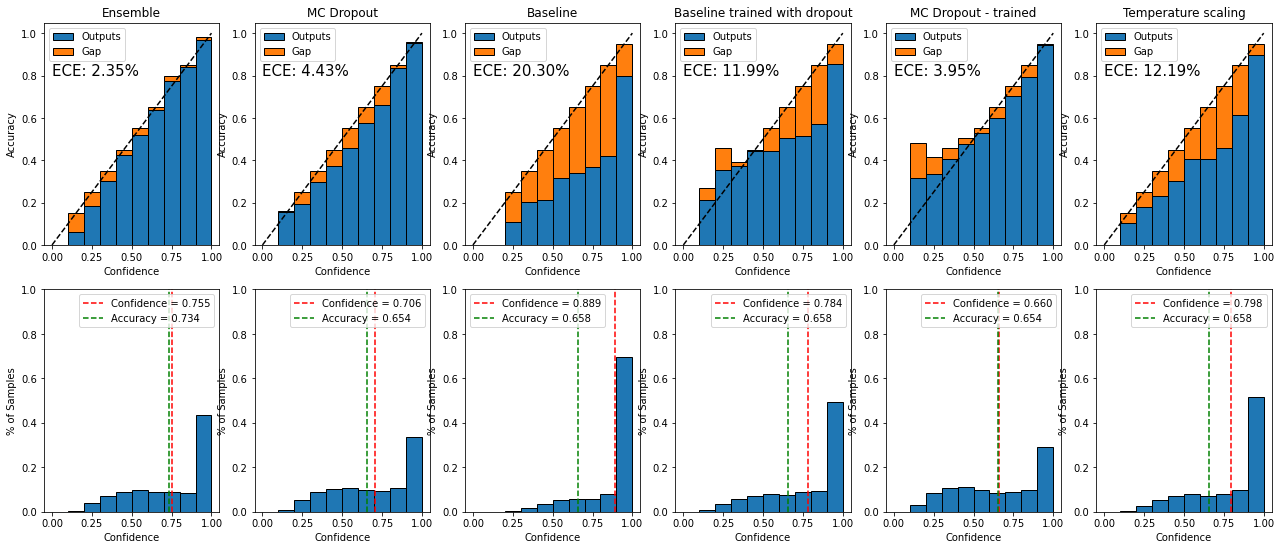

In [50]:
# nll = nn.CrossEntropyLoss()(torch.tensor(progress.logits), torch.tensor(
#     progress.labels, dtype=torch.long)).item()
# print(
#     f"Accuracy: {(progress.predictions==progress.labels).sum()*100/len(progress.labels):.2f}%, "
#     f"NLL: {nll:4f}"
# )

# mc_logits = progress.dropout_logits.mean(axis=0)
dropout_max_probs = progress_model.dropout_outputs.max(axis=-1)
trained_dropout_max_probs = progress_model_dropout.dropout_outputs.max(axis=-1)

ensemble_max_probs = progress_ensemble.logits.max(axis=1)
counts = utils.visualisations.calibration_graph([
    ("Ensemble", ensemble_max_probs, np.argsort(ensemble_max_probs), progress_ensemble.predictions),
    ("MC Dropout", dropout_max_probs, np.argsort(dropout_max_probs), progress_model.dropout_predictions),
    ("Baseline", progress_model.max_probs, np.argsort(progress_model.max_probs), progress_model.predictions),
    ("Baseline trained with dropout", progress_model_dropout.max_probs, np.argsort(progress_model.max_probs), progress_model.predictions),
    ("MC Dropout - trained", trained_dropout_max_probs, np.argsort(trained_dropout_max_probs), progress_model.dropout_predictions),
    ("Temperature scaling", progress_scaled_model.max_probs, np.argsort(progress_scaled_model.max_probs), progress_scaled_model.predictions)
    ],
    progress_model.labels,
    )

In [51]:
y_true = nn.functional.one_hot(torch.tensor(progress_model.labels.astype("long")))

print("Brier score")
print("Ensemble: " + str(compute_brier_score_avg(progress_ensemble.logits, y_true)))
print("MC Dropout: " + str(compute_brier_score_avg(progress_model.dropout_outputs, y_true)))
print("Baseline: " + str(compute_brier_score_avg(progress_model.probs, y_true)))
print("Baseline trained with dropout: " + str(compute_brier_score_avg(progress_model_dropout.probs, y_true)))
print("MC Dropout - trained: " + str(compute_brier_score_avg(progress_model_dropout.dropout_outputs, y_true)))
print("Temperature scaling: " + str(compute_brier_score_avg(progress_scaled_model.probs, y_true)))

Brier score
Ensemble: 0.003734451324129658
MC Dropout: 0.0046819619552039
Baseline: 0.00553298274156638
Baseline trained with dropout: 0.005241850545741098
MC Dropout - trained: 0.004697558103778875
Temperature scaling: 0.004887524234788005


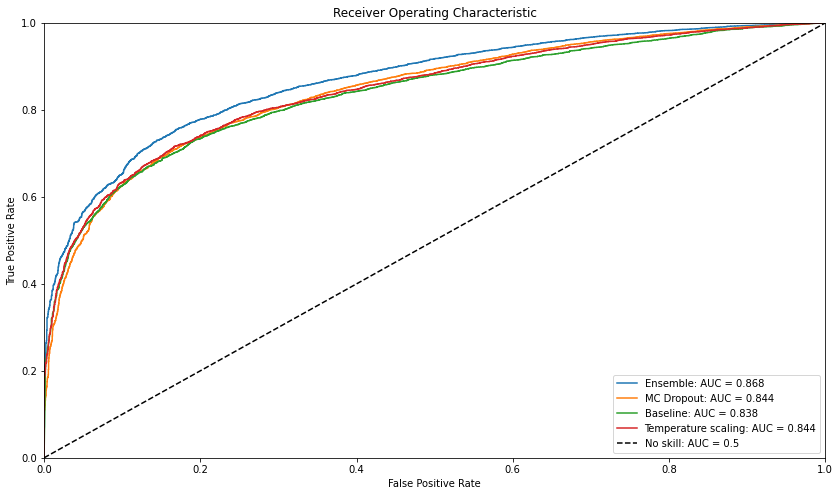

In [51]:
import sklearn.metrics as metrics
curves = []




correct = progress_ensemble.predictions == progress_ensemble.labels
max_probs = progress_ensemble.logits.max(axis=-1)
fpr, tpr, _ = metrics.roc_curve(correct, max_probs)
roc_auc = metrics.auc(fpr, tpr)

prec, recall, _ = metrics.precision_recall_curve(correct, max_probs)
aupr = metrics.auc(recall, prec)

curves.append({
    "fpr":fpr,
    "tpr":tpr,
    "auroc":roc_auc,
    "prec": prec,
    "recall": recall,
    "aupr": aupr,
    "label": "Ensemble"
})

correct = progress_model.dropout_predictions == progress_model.labels
dropout_max_probs = progress_model.dropout_outputs.max(axis=-1)
fpr, tpr, _ = metrics.roc_curve(correct, dropout_max_probs)
roc_auc = metrics.auc(fpr, tpr)

prec, recall, _ = metrics.precision_recall_curve(correct, dropout_max_probs)
aupr = metrics.auc(recall, prec)

curves.append({
    "fpr":fpr,
    "tpr":tpr,
    "auroc":roc_auc,
    "prec": prec,
    "recall": recall,
    "aupr": aupr,
    "label": "MC Dropout"
})

correct = progress_model.predictions == progress_model.labels
fpr, tpr, _ = metrics.roc_curve(correct, progress_model.max_probs)
roc_auc = metrics.auc(fpr, tpr)

prec, recall, _ = metrics.precision_recall_curve(correct, progress_model.max_probs)
aupr = metrics.auc(recall, prec)
curves.append({
    "fpr":fpr,
    "tpr":tpr,
    "auroc":roc_auc,
    "prec": prec,
    "recall": recall,
    "aupr": aupr,
    "label": "Baseline"
})

correct = progress_scaled_model.predictions == progress_scaled_model.labels
fpr, tpr, _ = metrics.roc_curve(correct, progress_scaled_model.max_probs)
roc_auc = metrics.auc(fpr, tpr)

prec, recall, _ = metrics.precision_recall_curve(correct, progress_scaled_model.max_probs)
aupr = metrics.auc(recall, prec)
curves.append({
    "fpr":fpr,
    "tpr":tpr,
    "auroc":roc_auc,
    "prec": prec,
    "recall": recall,
    "aupr": aupr,
    "label": "Temperature scaling"
})


plt.figure(figsize=(14,8))
plt.title('Receiver Operating Characteristic')
for curve in curves:
    plt.plot(curve["fpr"], curve["tpr"], label = f"{curve['label']}: AUC = {curve['auroc']:.3f}" )
plt.plot([0, 1], [0, 1],'k--', label=f"No skill: AUC = 0.5")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend()

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

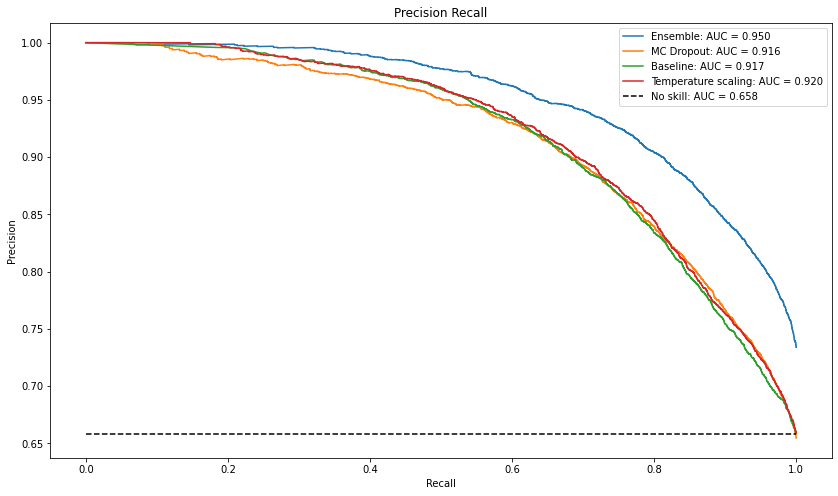

In [52]:
no_skill = correct.sum() / len(correct)
plt.figure(figsize=(14,8))
plt.title('Precision Recall')
for curve in curves:
    plt.plot(curve["recall"], curve["prec"], label=f"{curve['label']}: AUC = {curve['aupr']:.3f}")
# axis labels
plt.plot([0, 1], [no_skill, no_skill], color="k", linestyle='--', label=f'No skill: AUC = {no_skill:.3f}')

plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()